In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from copy import deepcopy
import random
import math

class TicTacToe:
    """TicTacToe Board."""

    EMPTY = ' '
    P1 = 'X'
    P2 = 'O'

    def __init__(self):
        """Initialize a TicTacToe board."""

        self.initial_state = []
        for i in range(3): #The board is a 3×3 list of lists.
            self.initial_state.append([' ']*3)

        self.players = (self.P1, self.P2)

        self.reset() # called to set the current state.

    @classmethod
    def switch_player(cls, player):
        """Class method that, given a player, returns its opponent"""

        return cls.P2 if player == cls.P1 else cls.P1 #Utility to switch between 'X' and 'O'.


    @classmethod
    def check_termination(cls, state):
        """
        Termination check.

        Returns
        -------
        done: bool
            A boolean indicating the termination

        winning_player: str
            The name of the winning player. The empty cell is returned in case of a draw.
        """

        done = False
        winning_player = ' '

        # Check rows
        for i in range(3):
            first_elem = state[i][0]
            if first_elem != cls.EMPTY:
                done = all(state[i][j]==first_elem for j in range(3))
                if done:
                    return done, first_elem

            # Check columns
            first_elem = state[0][i]
            if first_elem != cls.EMPTY:
                done = all(state[j][i]==first_elem for j in range(3))
                if done:
                    return done, first_elem

        # Check main diagonal 
        first_elem = state[0][0]
        if first_elem != cls.EMPTY:
            done = all(state[i][i]==first_elem for i in range(3))
            if done:
                return done, first_elem

        # Check anti-diagonal
        first_elem = state[0][2]
        if first_elem != cls.EMPTY:
            done = all(state[i][2-i]==first_elem for i in range(3))
            if done:
                return done, first_elem

        # Check draw (no empty cells)
        done = all(state[i][j] != cls.EMPTY for i in range(3) for j in range(3))

        return done, winning_player

    @classmethod
    def get_available_moves(cls, state):
        """Class method that, given a state, returns the free cells"""

        return [(i,j) for i in range(3) for j in range(3) if state[i][j] == ' ']

    @property
    def available_moves(self):
        """Available moves at current state"""

        return self.get_available_moves(self.current_state)

    @classmethod
    def transition_function(cls, state, action, player):
        """Transition function"""

        # asserts the chosen cell is empty.
        assert state[action[0]][action[1]] == cls.EMPTY

        #Places the player’s symbol
        state[action[0]][action[1]] = player
        #Switches the player to move.
        player = cls.switch_player(player)
        return state, player

    def step(self, action):
        """Step function"""

        # Check that the game is not already over
        self.done, winning_player = self.check_termination(self.current_state)
        assert self.done == False

        # Apply the action
        self.current_state, self.current_player = self.transition_function(self.current_state, action, self.current_player)

        # Re-check termination and compute reward 
        reward = 0
        self.done, winning_player = self.check_termination(self.current_state)
        # self.player is the one we care about when computing the reward
        if winning_player == self.player:
            reward = 1
        if winning_player == self.switch_player(self.player):
            reward = -1

        return self.current_state, reward, self.done, self.current_player

    def render(self, state=None):
        """Render function"""

        if state is None:
            state = self.current_state

        for i in range(3):
            print('-----------')
            print("|".join((f" {x} " for x in state[i])))
        print('-----------')
        print('###########')

    def reset(self, player=None):
        """
        Resets the environment.

        Player 'X' always moves first. If 'O' is selected, the first move is made
        """


        self.done = False
        self.player = player
        if self.player is None:
            self.player = self.P1

        self.current_state = deepcopy(self.initial_state)
        self.current_player = self.P1

        if player == self.P2:
            self.step(random.choice(self.available_moves))

        return self.current_state, self.current_player

![alt text](MCTS.png "Title")

In [13]:
class MCTSNode: # represent a node in the MCTS tree
    """MCTS Node."""

    def __init__(self, state, player, parent=None, action=None):
        """Initialize a node."""
        self.state = state  # current state
        self.player = player  # player to move
        self.parent = parent  # parent node
        self.action = action  # action taken to reach this node
        self.children = []  # list of child nodes
        self.untried_actions = TicTacToe.get_available_moves(state)  # actions not yet tried
        self.visits = 0  # number of times node was visited
        self.wins = 0  # number of wins from this node
        self.n = 0  # alias for visits
        self.w = 0  # alias for wins
        self.is_terminal = TicTacToe.check_termination(self.state)[0]

    @property
    def fully_expanded(self):
        # true if we don't have any actions
        return len(self.untried_actions)==0

    def expand(self):
        """Pick an untried action, evaluate it, generate the node for the resulting state (also add it to the children) and return it."""
        action = random.choice(self.untried_actions)
        self.untried_actions.remove(action)

        next_state, next_player = TicTacToe.transition_function(deepcopy(self.state), action, self.player) #deepcopy copy also the internal variable of the state
        
        child_node = MCTSNode(next_state, next_player, parent=self, action=action)
        self.children.append(child_node)
        return child_node

    def rollout(self):
        """Until termination, move randomly. Return the result (winning player)"""
        state = deepcopy(self.state)
        player = self.player
        done, result = TicTacToe.check_termination(state)

        while not done:
            possible_actions = TicTacToe.get_available_moves(state)
            action = random.choice(possible_actions)
            state, player = TicTacToe.transition_function(deepcopy(state), action, player)
            done, result = TicTacToe.check_termination(state)

        return result


    def backpropagate(self, result):
        """Backprop the result of a rollout up to the root node: For each node in the path update the visits and the number of wins"""
        self.n += 1 # increase the number of visits
        if self.parent:
            # if the winning player is the parent of player
            if result == self.parent.player:
                self.w += 1
            elif result != ' ':
                self.w -= 1

            self.parent.backpropagate(result)


    def traverse(self, c=2.0):
        """Traverse the nodes until an unexpanded one is found or termination is reached"""
        node = self # current node
        
        while node.fully_expanded and not node.is_terminal:
            node = node.best_uct_child(c)
        
        # if terminal, return the node itself
        if node.is_terminal:
            return node
        
        # otherwise expand
        return node.expand()


    def win_ratio(self): 
        """Win Ratio of a node"""
        if self.n == 0:
            return 0
        return self.w/self.n

    def uct(self, c=2.0):
        """UCT value of a node"""
        if self.n == 0:
            return float('inf')
        return self.win_ratio() + c * math.sqrt(math.log(self.parent.n) / self.n)

    def best_child(self): 
        """Return the best child (the one with the highest win ratio)"""
        best_win_ratio, child = max((self.children[i].win_ratio(), i) for i in range(len(self.children)))
        return self.children[child]
        
    def best_uct_child(self, c=2.0): 
        """Return the best child according to UCT"""
        best_uct_value, child = max((self.children[i].uct(c), i) for i in range(len(self.children)))

        return self.children[child]


In [5]:
def mcts(state, player, c=2.0, iters=5000):
    root = MCTSNode(deepcopy(state), player)
    for i in range(iters): # Repeat for iters iterations.
        leaf = root.traverse(c) # selection + expansion
        simulation_result = leaf.rollout() # simulation
        leaf.backpropagate(simulation_result) # backpropagation
    
    #root.best_child().action is the action with the highest win ratio.
    # the function also returns the root node itself (useful if you want to inspect the tree).
    return root.best_child().action, root

In [6]:
player = 'X'

In [11]:
env = TicTacToe()

# Random Agents (X and O)

In [8]:
rewards = []
for i in range(10):
    state, cur_player = env.reset(player)
    done = False
    total_reward = 0
    while not done:
        action = random.choice(env.available_moves)
        state, reward, done, cur_player = env.step(action)
        total_reward += reward
    rewards.append(total_reward)

print('Mean Reward over 10 episodes:', sum(rewards)/len(rewards))

Mean Reward over 10 episodes: 0.2


# MCTS Agent (X) and Random Agend (O)

In [14]:
state, cur_player = env.reset(player)
done = False

env.render()

while not done:
    if cur_player == player:
        action, root = mcts(deepcopy(state), player)
    else:
        action = random.choice(env.available_moves)
    state, reward, done, cur_player = env.step(action)
    env.render()

-----------
   |   |   
-----------
   |   |   
-----------
   |   |   
-----------
###########
-----------
   |   |   
-----------
   | X |   
-----------
   |   |   
-----------
###########
-----------
   |   | O 
-----------
   | X |   
-----------
   |   |   
-----------
###########
-----------
   |   |   
-----------
   | X |   
-----------
   |   |   
-----------
###########
-----------
   |   | O 
-----------
   | X |   
-----------
   |   |   
-----------
###########
-----------
   |   | O 
-----------
   | X | X 
-----------
   |   |   
-----------
###########
-----------
 O |   | O 
-----------
   | X | X 
-----------
   |   |   
-----------
###########
-----------
 O |   | O 
-----------
 X | X | X 
-----------
   |   |   
-----------
###########
-----------
   |   | O 
-----------
   | X | X 
-----------
   |   |   
-----------
###########
-----------
 O |   | O 
-----------
   | X | X 
-----------
   |   |   
-----------
###########
-----------
 O |   | O 
-----------
 X |

In [15]:
rewards = []
for i in range(10):
    state, cur_player = env.reset(player)
    done = False

    total_reward = 0
    while not done:
        if cur_player == player:
            action, root = mcts(deepcopy(state), player)
        else:
            action = random.choice(env.available_moves)
        state, reward, done, cur_player = env.step(action)
        total_reward += reward
    rewards.append(total_reward)

print('Mean Reward over 10 episodes:', sum(rewards)/len(rewards))

Mean Reward over 10 episodes: 1.0


# MCTS Agents (X and O)

In [16]:
state, cur_player = env.reset(player)
done = False

env.render()

while not done:
    action, root = mcts(deepcopy(state), cur_player)
    state, reward, done, cur_player = env.step(action)
    env.render()

-----------
   |   |   
-----------
   |   |   
-----------
   |   |   
-----------
###########
-----------
   |   |   
-----------
   | X |   
-----------
   |   |   
-----------
###########
-----------
   |   |   
-----------
   | X |   
-----------
   |   |   
-----------
###########
-----------
 O |   |   
-----------
   | X |   
-----------
   |   |   
-----------
###########
-----------
 O |   |   
-----------
   | X |   
-----------
   |   |   
-----------
###########
-----------
 O |   |   
-----------
 X | X |   
-----------
   |   |   
-----------
###########
-----------
 O |   |   
-----------
 X | X | O 
-----------
   |   |   
-----------
###########
-----------
 O |   |   
-----------
 X | X |   
-----------
   |   |   
-----------
###########
-----------
 O |   |   
-----------
 X | X | O 
-----------
   |   |   
-----------
###########
-----------
 O | X |   
-----------
 X | X | O 
-----------
   |   |   
-----------
###########
-----------
 O | X |   
-----------
 X |

In [17]:
rewards = []
for i in range(10):
    state, cur_player = env.reset(player)
    done = False

    total_reward = 0
    while not done:
        action, root = mcts(deepcopy(state), cur_player)
        state, reward, done, cur_player = env.step(action)
        total_reward += reward
    rewards.append(total_reward)

print('Mean Reward over 10 episodes:', sum(rewards)/len(rewards))

Mean Reward over 10 episodes: 0.0


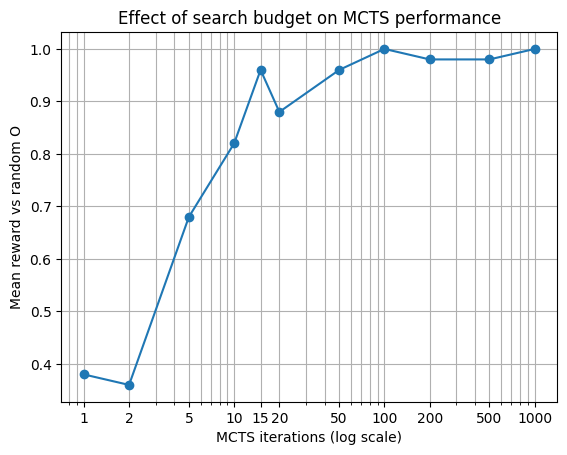

In [18]:
import numpy as np
import matplotlib.pyplot as plt

iters_list = [1, 2, 5, 10, 15, 20, 50, 100, 200, 500, 1000]
n_episodes = 50

mean_rewards = []

for iters in iters_list:
    rewards = []
    for _ in range(n_episodes):
        state, cur_player = env.reset(player='X')
        done = False
        total_reward = 0
        while not done:
            if cur_player == 'X':
                action, _ = mcts(state, player='X', iters=iters)
            else:
                action = random.choice(env.available_moves)
            state, reward, done, cur_player = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    mean_rewards.append(np.mean(rewards))

# plt.plot(iters_list, mean_rewards, marker='o')
# plt.xlabel("MCTS iterations")
# plt.ylabel("Mean reward vs random O")
# plt.title("Effect of search budget on MCTS performance")
# plt.grid(True)
# plt.show()
plt.semilogx(iters_list, mean_rewards, marker='o')
plt.xticks(iters_list, iters_list)  # show your exact iteration values
plt.xlabel("MCTS iterations (log scale)")
plt.ylabel("Mean reward vs random O")
plt.title("Effect of search budget on MCTS performance")
plt.grid(True, which="both")
plt.show()


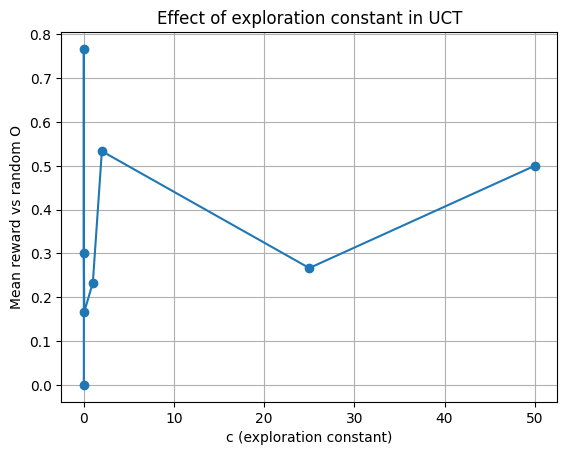

In [20]:
cs = [0.00001, 0.0005, 0.001, 0.05, 1.0, 2.0, 25.0, 50.0]
mean_rewards = []

for c in cs:
    rewards = []
    for _ in range(30):
        state, cur_player = env.reset(player='X')
        done = False
        total_reward = 0
        while not done:
            if cur_player == 'X':
                action, _ = mcts(state, player='X', iters=1, c=c)
            else:
                action = random.choice(env.available_moves)
                # action, _ = mcts(state, player='O', iters=500, c=2)
            state, reward, done, cur_player = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    mean_rewards.append(np.mean(rewards))

plt.plot(cs, mean_rewards, marker='o')
plt.xlabel("c (exploration constant)")
plt.ylabel("Mean reward vs random O")
plt.title("Effect of exploration constant in UCT")
plt.grid(True)
plt.show()
